# [課題]kickstarter

kickstarter:https://www.kickstarter.com/?lang=ja

kaggle URL:https://www.kaggle.com/kemical/kickstarter-projects

目的:クラウドファンディングが成功するかどうか予測する → 目的変数をstateとする分類問題

# 1. データセットの確認

参考:https://www.kaggle.com/kemical/kickstarter-projects/discussion

- ID：通し番号
- name：プロジェクト名
- category：プロジェクカテゴリ
- main_category：大きい括りのカテゴリ
- currency：募集する際の通貨
- deadline：締切日
- goal：目標の金額
- launched：募集開始日
- pledged：支援された額
- state：プロジェクトの今の状態（成功、失敗、キャンセル etc.）
- backers：プロジェクト支援数（≒製品を買った人）
- country：どの国のプロジェクトか
- usd pledged：支援額（kickstarterが計算したドル換算）
- usd_pledged_real：支援額（fixer.io apiが計算したドル換算）
- usd_goal_real：目標の金額（ドル換算）

目的変数は**state**であることがわかる

また、以下のプロジェクト終了後に分かる項目は不要なので削除する

- pledged
- backers
- usd pledged
- usd_pledged_real

In [5]:
#ライブラリ読み込み
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
from sklearn import preprocessing

In [6]:
#使用する変数の行を指定して読み込み
df_kickstarter = pd.read_csv("ks-projects-201801.csv",usecols=['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'state', 'country', 'usd_goal_real'] )
# kikstarterのデータを見る
display(df_kickstarter.head())
display(df_kickstarter.describe(include='all'))
#欠損値がある行数を数えてみる。
display(df_kickstarter.isnull().sum())
#各列のデータタイプを確認してみる。
display(df_kickstarter.dtypes)

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched     state country  usd_goal_real  
0  2015-08-11 12:12:28    failed      GB        1533.95  
1  2017-09-02 04:43:57    failed      US       30000.00  
2  2013-01-12 00:20:50    failed      US       45000.00  
3  2012-03-17 03:24:11    failed      US        5000.00  
4  2015-07-04 08:35:03  canceled      US       19500.00

ID                      name        category main_category  \
count   3.786610e+05                    378657          378661        378661   
unique           NaN                    375764             159            15   
top              NaN  New EP/Music Development  Product Design  Film & Video   
freq             NaN                        41           22314         63585   
mean    1.074731e+09                       NaN             NaN           NaN   
std     6.190862e+08                       NaN             NaN           NaN   
min     5.971000e+03                       NaN             NaN           NaN   
25%     5.382635e+08                       NaN             NaN           NaN   
50%     1.075276e+09                       NaN             NaN           NaN   
75%     1.610149e+09                       NaN             NaN           NaN   
max     2.147476e+09                       NaN             NaN           NaN   

       currency    deadline          goal             launched   state  \
count    378661      378661  3.786610e+05               378661  378661   
unique       14        3164           NaN               378089       6   
top         USD  2014-08-08           NaN  1970-01-01 01:00:00  failed   
freq     295365         705           NaN                    7  197719   
mean        NaN         NaN  4.908079e+04                  NaN     NaN   
std         NaN         NaN  1.183391e+06                  NaN     NaN   
min         NaN         NaN  1.000000e-02                  NaN     NaN   
25%         NaN         NaN  2.000000e+03                  NaN     NaN   
50%         NaN         NaN  5.200000e+03                  NaN     NaN   
75%         NaN         NaN  1.600000e+04                  NaN     NaN   
max         NaN         NaN  1.000000e+08                  NaN     NaN   

       country  usd_goal_real  
count   378661   3.786610e+05  
unique      23            NaN  
top         US            NaN  
freq    292627            NaN  
mean       NaN   4.545440e+04  
std        NaN   1.152950e+06  
min        NaN   1.000000e-02  
25%        NaN   2.000000e+03  
50%        NaN   5.500000e+03  
75%        NaN   1.550000e+04  
max        NaN   1.663614e+08

ID               0
name             4
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

ID                 int64
name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
state             object
country           object
usd_goal_real    float64
dtype: object

In [7]:
display(df_kickstarter['state'].unique())

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

- failed：失敗
- canceled:中止
- successful:成功
- live:継続中
- undifined:未定義,ゴールを設けていない?
- suspended:規約違反で中断

成功するかどうかの予測のため、**successful**と**failed**のデータを扱う

In [8]:
df_kickstarter = df_kickstarter.query('state in ["failed", "successful"]')

In [9]:
display(df_kickstarter['category'].value_counts())
display(df_kickstarter['main_category'].value_counts())
display(df_kickstarter['country'].value_counts())

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [10]:
display(df_kickstarter['category'].unique())
display(df_kickstarter['main_category'].unique())
display(df_kickstarter['country'].unique())

array(['Poetry', 'Narrative Film', 'Music', 'Restaurants', 'Food',
       'Drinks', 'Nonfiction', 'Indie Rock', 'Crafts', 'Games',
       'Tabletop Games', 'Design', 'Comic Books', 'Art Books', 'Fashion',
       'Childrenswear', 'Theater', 'Comics', 'DIY', 'Webseries',
       'Animation', 'Food Trucks', 'Product Design', 'Public Art',
       'Documentary', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Film & Video', 'Accessories', 'Rock',
       'Hardware', 'Software', 'Weaving', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Gadgets', 'Electronic Music', 'Radio & Podcasts', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       "Childre

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'NL', 'LU', 'SG', 'N,0"',
       'JP'], dtype=object)

In [11]:
#開始日と締切日から募集期間を出し、新たな特徴変数として加える
df_kickstarter = df_kickstarter.astype({'deadline':'datetime64','launched':'datetime64'})
time_to_deadline = df_kickstarter['deadline'] - df_kickstarter['launched']
display(time_to_deadline[:5])

time_to_deadline_days = time_to_deadline.dt.days
df_kickstarter['Days to deadline'] = time_to_deadline_days
display(df_kickstarter['Days to deadline'][:5])


0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
5   34 days 10:21:33
dtype: timedelta64[ns]

0    58
1    59
2    44
3    29
5    34
Name: Days to deadline, dtype: int64

In [12]:
#failedを0,successfulを1に変換
df_kickstarter["state"] = df_kickstarter["state"].replace({"failed": 0,
                                            "successful": 1})

#country,main_category,categoryをOne-Hotに変換。
df_train = pd.get_dummies(df_kickstarter, columns=['country', 'category', 'main_category'])
#予測したいstateを正解データに入れる
train_label = df_train['state']

#確認
display(df_kickstarter.head())
display(df_kickstarter.describe(include='all'))

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
5  1000014025                               Monarch Espresso Bar   

         category main_category currency   deadline     goal  \
0          Poetry    Publishing      GBP 2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD 2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD 2013-02-26  45000.0   
3           Music         Music      USD 2012-04-16   5000.0   
5     Restaurants          Food      USD 2016-04-01  50000.0   

             launched  state country  usd_goal_real  Days to deadline  
0 2015-08-11 12:12:28      0      GB        1533.95                58  
1 2017-09-02 04:43:57      0      US       30000.00                59  
2 2013-01-12 00:20:50      0      US       45000.00                44  
3 2012-03-17 03:24:11      0      US        5000.00                29  
5 2016-02-26 13:38:27      1      US       50000.00                34

ID                      name        category main_category  \
count   3.316750e+05                    331672          331675        331675   
unique           NaN                    329594             159            15   
top              NaN  New EP/Music Development  Product Design  Film & Video   
freq             NaN                        15           18680         56527   
first            NaN                       NaN             NaN           NaN   
last             NaN                       NaN             NaN           NaN   
mean    1.074271e+09                       NaN             NaN           NaN   
std     6.191924e+08                       NaN             NaN           NaN   
min     5.971000e+03                       NaN             NaN           NaN   
25%     5.371725e+08                       NaN             NaN           NaN   
50%     1.074573e+09                       NaN             NaN           NaN   
75%     1.609844e+09                       NaN             NaN           NaN   
max     2.147476e+09                       NaN             NaN           NaN   

       currency             deadline          goal             launched  \
count    331675               331675  3.316750e+05               331675   
unique       14                 3102           NaN               331255   
top         USD  2014-08-08 00:00:00           NaN  2012-04-10 00:47:19   
freq     261511                  612           NaN                    2   
first       NaN  2009-05-03 00:00:00           NaN  2009-04-21 21:02:48   
last        NaN  2018-01-02 00:00:00           NaN  2017-12-29 03:22:32   
mean        NaN                  NaN  4.425157e+04                  NaN   
std         NaN                  NaN  1.117917e+06                  NaN   
min         NaN                  NaN  1.000000e-02                  NaN   
25%         NaN                  NaN  2.000000e+03                  NaN   
50%         NaN                  NaN  5.000000e+03                  NaN   
75%         NaN                  NaN  1.500000e+04                  NaN   
max         NaN                  NaN  1.000000e+08                  NaN   

                state country  usd_goal_real  Days to deadline  
count   331675.000000  331675   3.316750e+05     331675.000000  
unique            NaN      23            NaN               NaN  
top               NaN      US            NaN               NaN  
freq              NaN  261360            NaN               NaN  
first             NaN     NaN            NaN               NaN  
last              NaN     NaN            NaN               NaN  
mean         0.403877     NaN   4.151000e+04         32.954902  
std          0.490674     NaN   1.108930e+06         12.713329  
min          0.000000     NaN   1.000000e-02          0.000000  
25%          0.000000     NaN   2.000000e+03         29.000000  
50%          0.000000     NaN   5.000000e+03         29.000000  
75%          1.000000     NaN   1.500000e+04         35.000000  
max          1.000000     NaN   1.663614e+08         91.000000

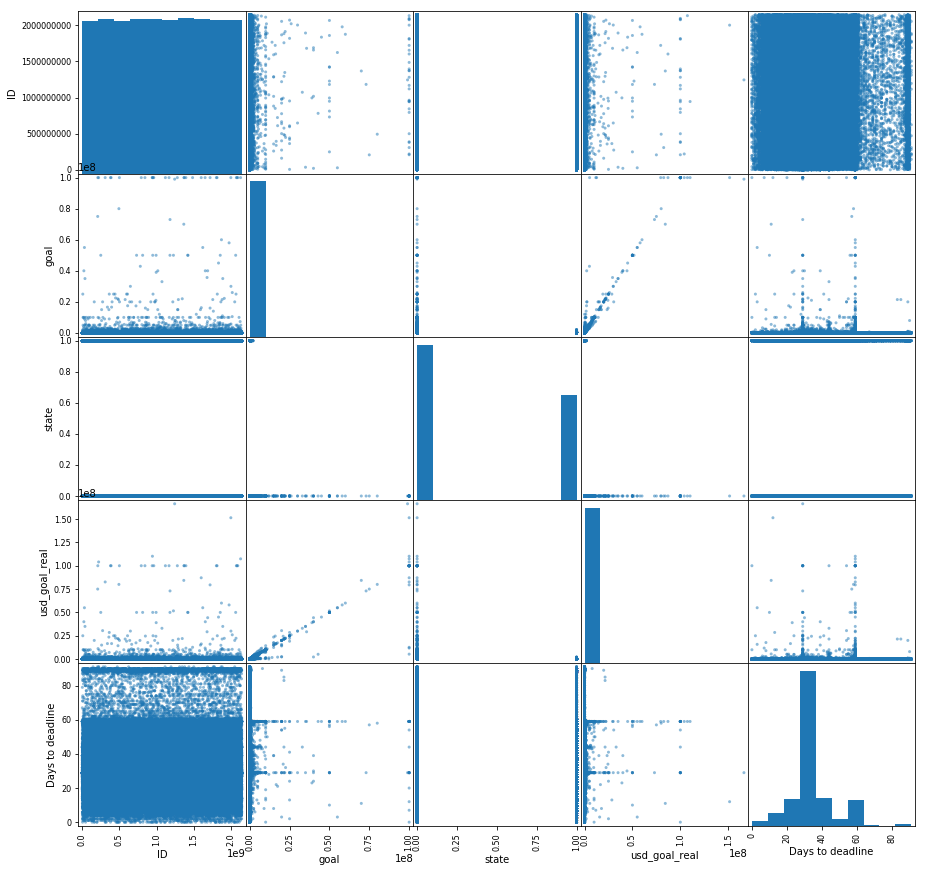

In [26]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df_kickstarter, figsize=(15,15))
plt.show()

In [27]:
# 相関係数を確認
df_kickstarter.corr()

ID      goal     state  usd_goal_real  \
ID                1.000000  0.001900 -0.000722       0.001844   
goal              0.001900  1.000000 -0.025099       0.952614   
state            -0.000722 -0.025099  1.000000      -0.023735   
usd_goal_real     0.001844  0.952614 -0.023735       1.000000   
Days to deadline  0.002816  0.022692 -0.116437       0.021607   

                  Days to deadline  
ID                        0.002816  
goal                      0.022692  
state                    -0.116437  
usd_goal_real             0.021607  
Days to deadline          1.000000

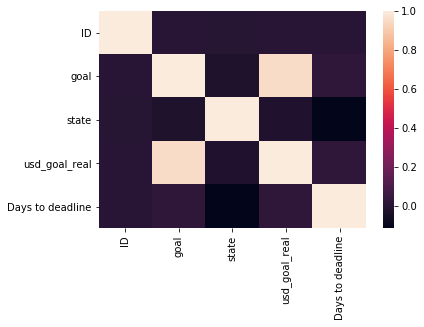

In [28]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_kickstarter.corr())
plt.show()

In [13]:
#trainデータに入れる
train_data = df_train.drop(['ID','state','name','currency','deadline','goal','launched'], axis=1)
#確認
display(train_data.head())
display(train_data.describe(include='all'))

usd_goal_real  Days to deadline  country_AT  country_AU  country_BE  \
0        1533.95                58           0           0           0   
1       30000.00                59           0           0           0   
2       45000.00                44           0           0           0   
3        5000.00                29           0           0           0   
5       50000.00                34           0           0           0   

   country_CA  country_CH  country_DE  country_DK  country_ES  ...  \
0           0           0           0           0           0  ...   
1           0           0           0           0           0  ...   
2           0           0           0           0           0  ...   
3           0           0           0           0           0  ...   
5           0           0           0           0           0  ...   

   main_category_Fashion  main_category_Film & Video  main_category_Food  \
0                      0                           0                   0   
1                      0                           1                   0   
2                      0                           1                   0   
3                      0                           0                   0   
5                      0                           0                   1   

   main_category_Games  main_category_Journalism  main_category_Music  \
0                    0                         0                    0   
1                    0                         0                    0   
2                    0                         0                    0   
3                    0                         0                    1   
5                    0                         0                    0   

   main_category_Photography  main_category_Publishing  \
0                          0                         1   
1                          0                         0   
2                          0                         0   
3                          0                         0   
5                          0                         0   

   main_category_Technology  main_category_Theater  
0                         0                      0  
1                         0                      0  
2                         0                      0  
3                         0                      0  
5                         0                      0  

[5 rows x 199 columns]

usd_goal_real  Days to deadline     country_AT     country_AU  \
count   3.316750e+05     331675.000000  331675.000000  331675.000000   
mean    4.151000e+04         32.954902       0.001462       0.019947   
std     1.108930e+06         12.713329       0.038212       0.139819   
min     1.000000e-02          0.000000       0.000000       0.000000   
25%     2.000000e+03         29.000000       0.000000       0.000000   
50%     5.000000e+03         29.000000       0.000000       0.000000   
75%     1.500000e+04         35.000000       0.000000       0.000000   
max     1.663614e+08         91.000000       1.000000       1.000000   

          country_BE     country_CA     country_CH     country_DE  \
count  331675.000000  331675.000000  331675.000000  331675.000000   
mean        0.001577       0.037296       0.001966       0.010360   
std         0.039678       0.189485       0.044294       0.101253   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          country_DK     country_ES  ...  main_category_Fashion  \
count  331675.000000  331675.000000  ...          331675.000000   
mean        0.002792       0.005647  ...               0.059622   
std         0.052765       0.074935  ...               0.236785   
min         0.000000       0.000000  ...               0.000000   
25%         0.000000       0.000000  ...               0.000000   
50%         0.000000       0.000000  ...               0.000000   
75%         0.000000       0.000000  ...               0.000000   
max         1.000000       1.000000  ...               1.000000   

       main_category_Film & Video  main_category_Food  main_category_Games  \
count               331675.000000       331675.000000        331675.000000   
mean                     0.170429            0.066493             0.085991   
std                      0.376010            0.249142             0.280351   
min                      0.000000            0.000000             0.000000   
25%                      0.000000            0.000000             0.000000   
50%                      0.000000            0.000000             0.000000   
75%                      0.000000            0.000000             0.000000   
max                      1.000000            1.000000             1.000000   

       main_category_Journalism  main_category_Music  \
count             331675.000000        331675.000000   
mean                   0.012509             0.138536   
std                    0.111143             0.345462   
min                    0.000000             0.000000   
25%                    0.000000             0.000000   
50%                    0.000000             0.000000   
75%                    0.000000             0.000000   
max                    1.000000             1.000000   

       main_category_Photography  main_category_Publishing  \
count              331675.000000             331675.000000   
mean                    0.029212                  0.106867   
std                     0.168401                  0.308944   
min                     0.000000                  0.000000   
25%                     0.000000                  0.000000   
50%                     0.000000                  0.000000   
75%                     0.000000                  0.000000   
max                     1.000000                  1.000000   

       main_category_Technology  main_category_Theater  
count             331675.000000          331675.000000  
mean                   0.081556               0.030880  
std                    0.273687               0.172992  
min                    0.000000               0.000000  
25%                    0.000000               0.000000  
50%                    

In [14]:
#標準化
train_data = (train_data - train_data.mean()) / train_data.std()
train_data = train_data.astype('float32')

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X_train, X_test, Y_train, Y_test = train_test_split(train_data, train_label, test_size=0.3,shuffle=True, random_state=1234) 

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(232172, 199) (99503, 199) (232172,) (99503,)


In [17]:
#決定木の深さの検討
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
param_grid = {'max_depth': [2, 3, 4, 5]}
clf = DecisionTreeClassifier(criterion="gini", min_samples_split=2, min_samples_leaf=2, random_state=1234)


grid_search = GridSearchCV(clf, param_grid, iid=True, cv=5, return_train_score=True)
grid_search.fit(X_train, Y_train)
print('best score: {:0.3f}'.format(grid_search.score(X_test, Y_test)))
print('best params: {}'.format(grid_search.best_params_))
print('best val score:  {:0.3f}'.format(grid_search.best_score_))

best score: 0.638
best params: {'max_depth': 5}
best val score:  0.638


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, Y_train)
print("score=", clf.score(X_test, Y_test))



score= 0.6756881702059234


In [19]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)

fi = clf.feature_importances_

# associate the feature importance values with the proper training columns
fi_df = pd.DataFrame({
    "feature": list(X_train.columns),
    "feature_importance": fi
})

# sort the rows by feature importance value
fi_df = fi_df.sort_values("feature_importance", ascending=False)
fi_df = fi_df.query('feature_importance > 0.002')
print(fi_df)


[2.22522107e-01 1.12295634e-01 0.00000000e+00 1.50878213e-03
 1.32218010e-03 1.14019916e-03 0.00000000e+00 3.65078185e-04
 6.49507980e-04 0.00000000e+00 3.60351819e-03 1.73242050e-02
 0.00000000e+00 0.00000000e+00 6.14021344e-03 0.00000000e+00
 0.00000000e+00 2.22903179e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.27948812e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.16206488e-03
 2.29456069e-03 2.84536359e-02 0.00000000e+00 0.00000000e+00
 1.80385295e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.10309276e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.09139823e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.48353584e-02
 0.00000000e+00 8.31112269e-04 0.00000000e+00 5.83345277e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.41440760e-02
 8.71012012e-03 0.000000

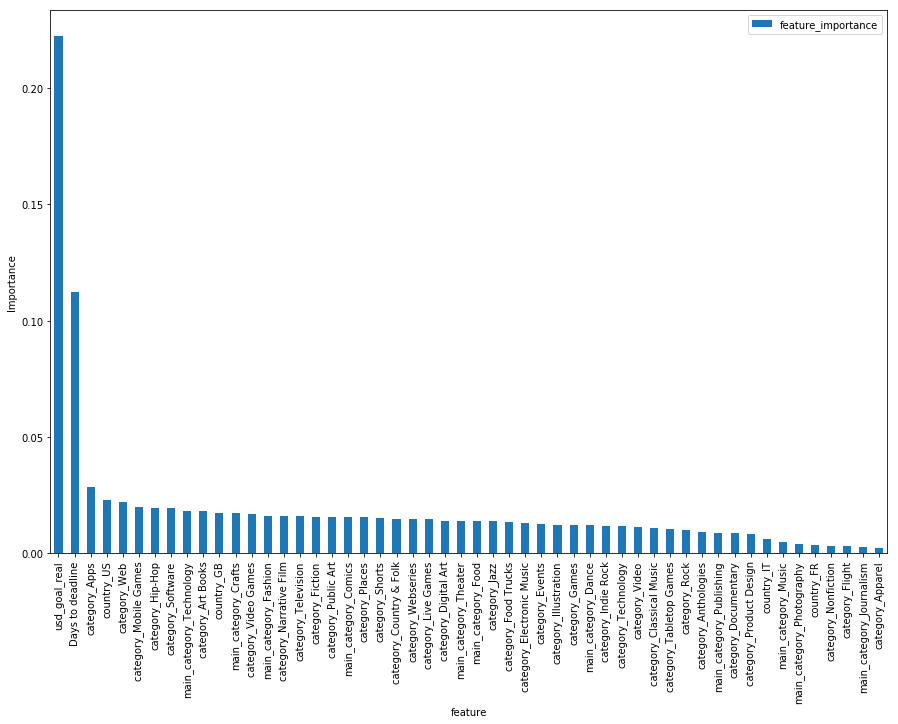

In [20]:
fi_df.plot.bar(figsize=(15,10),x='feature', y='feature_importance')
plt.xlabel("feature")
plt.ylabel("Importance")
plt.show()

In [24]:
display(type(X_train.columns))

pandas.core.indexes.base.Index

0


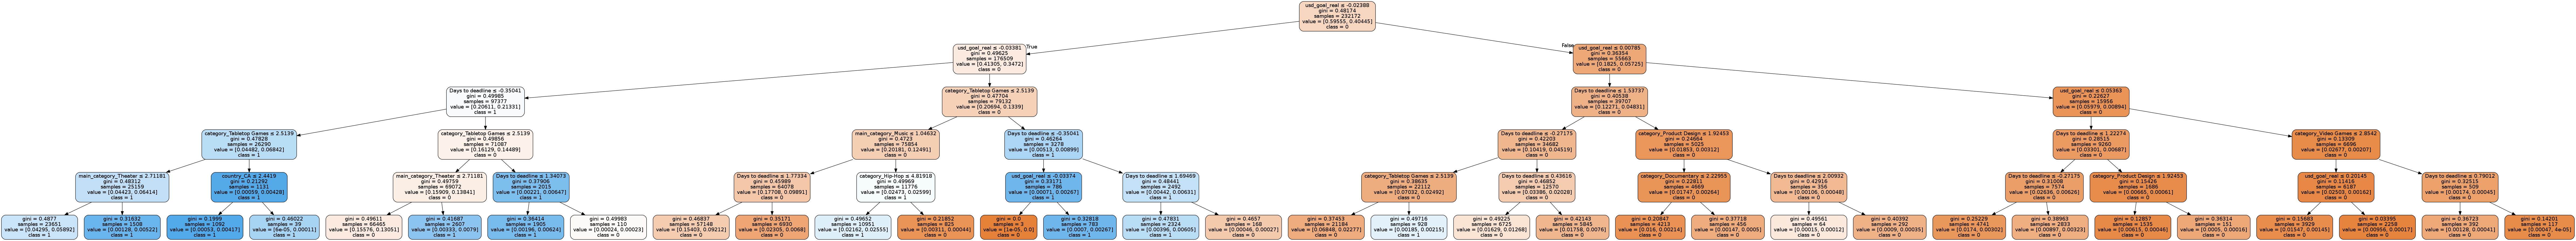

1


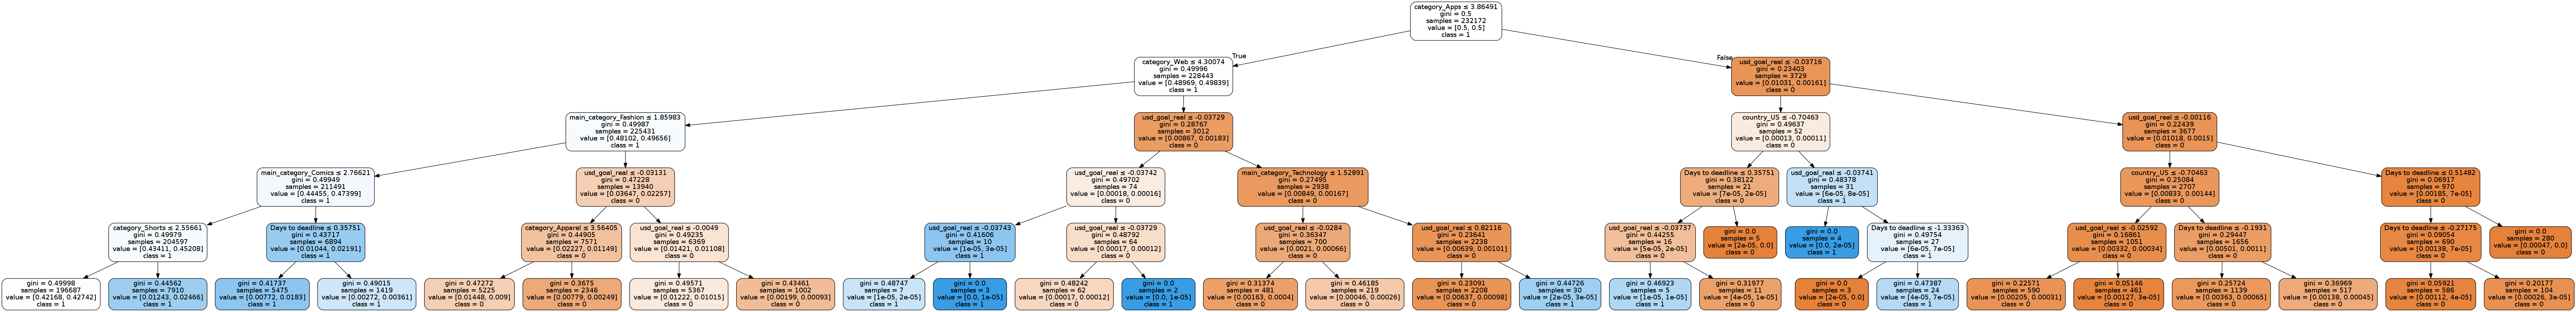

2


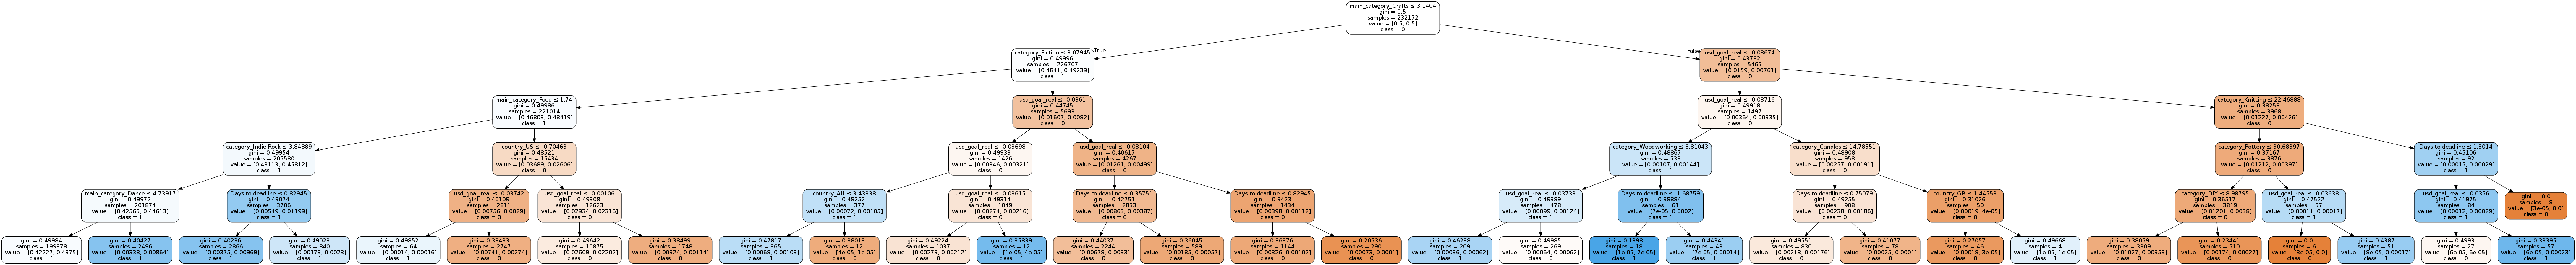

3
4


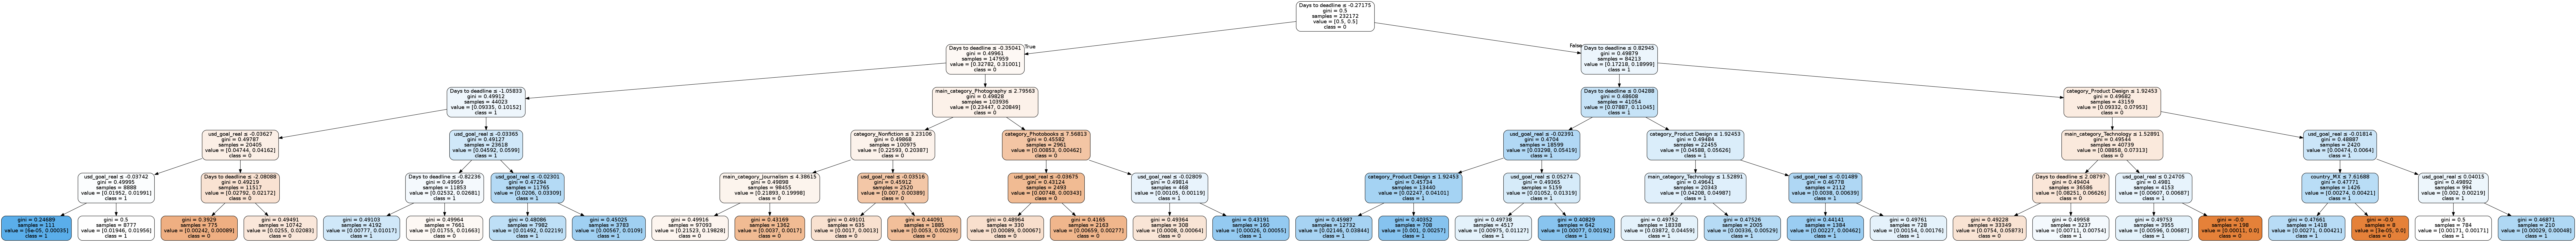

5


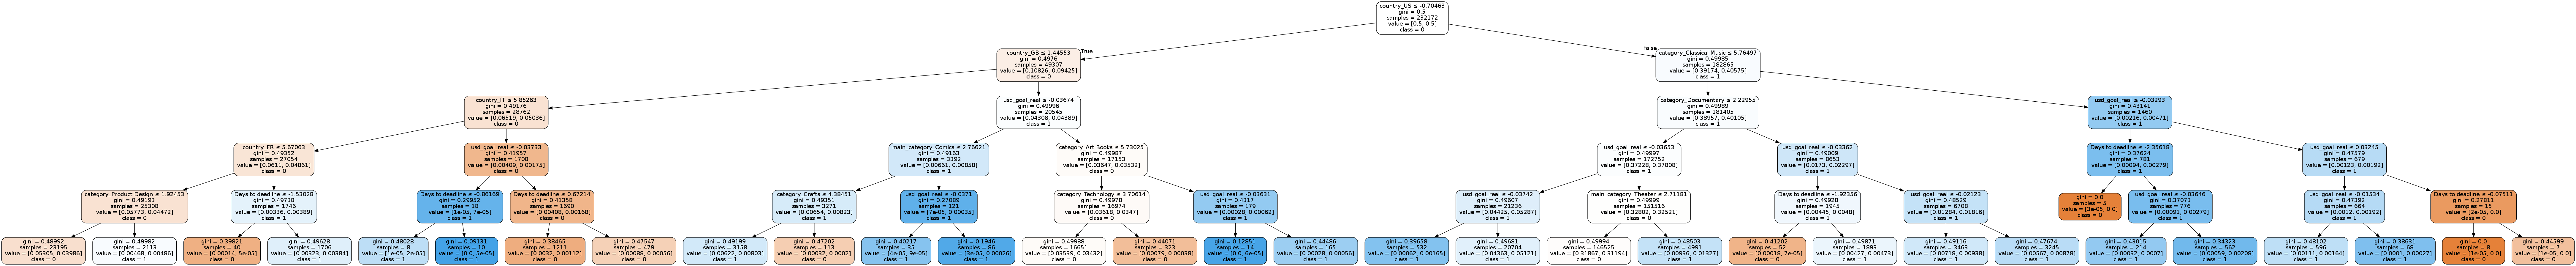

6


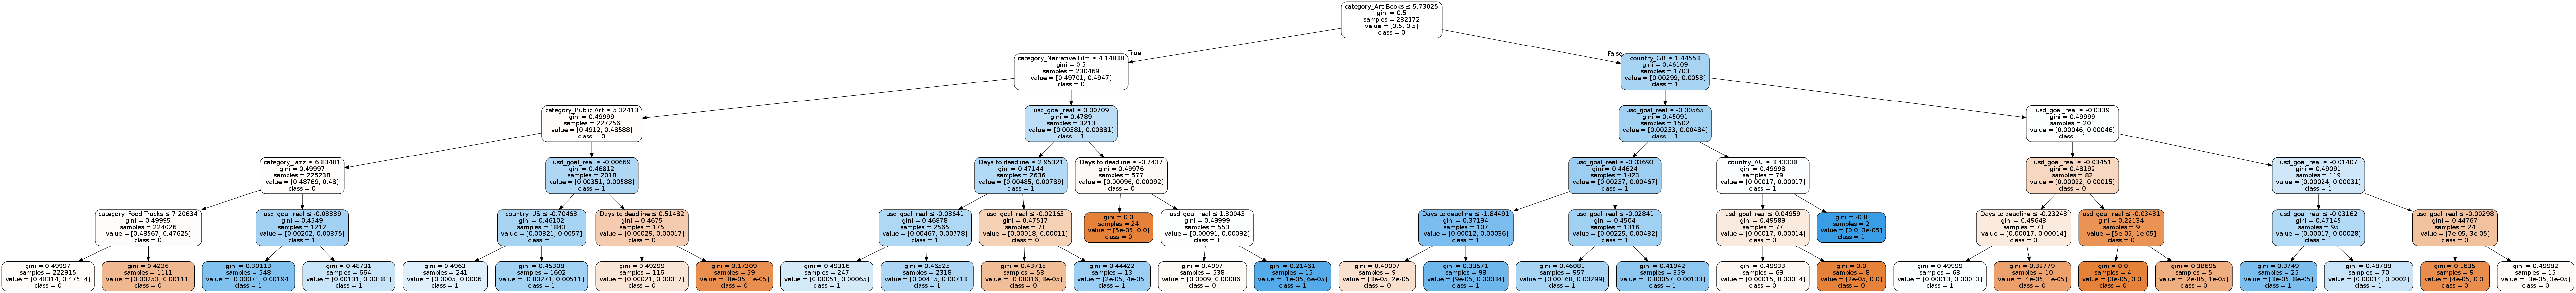

7


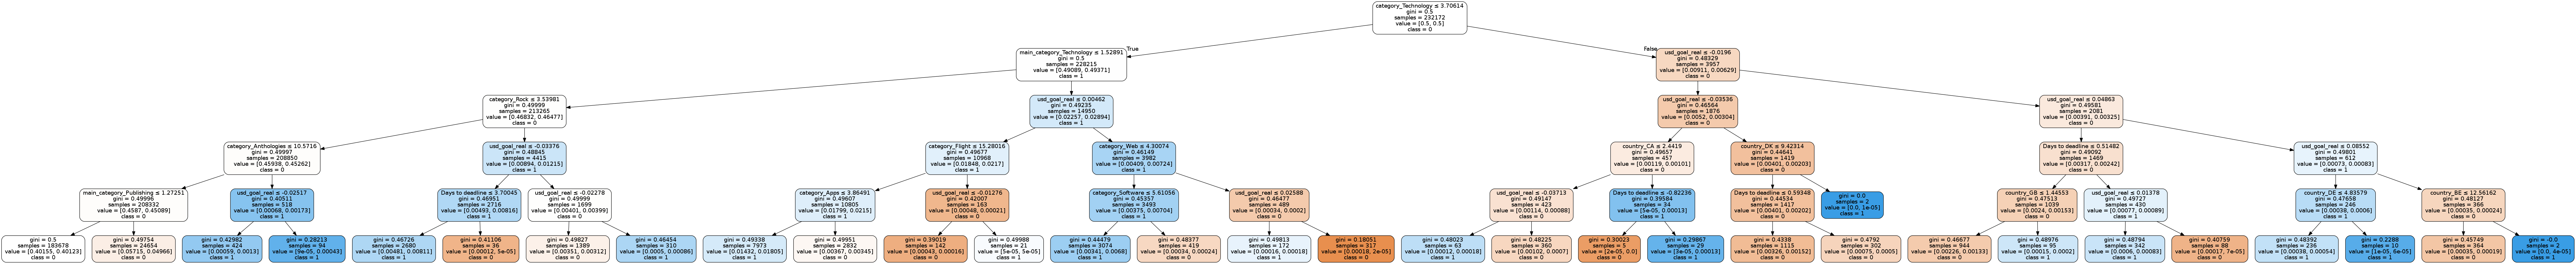

8


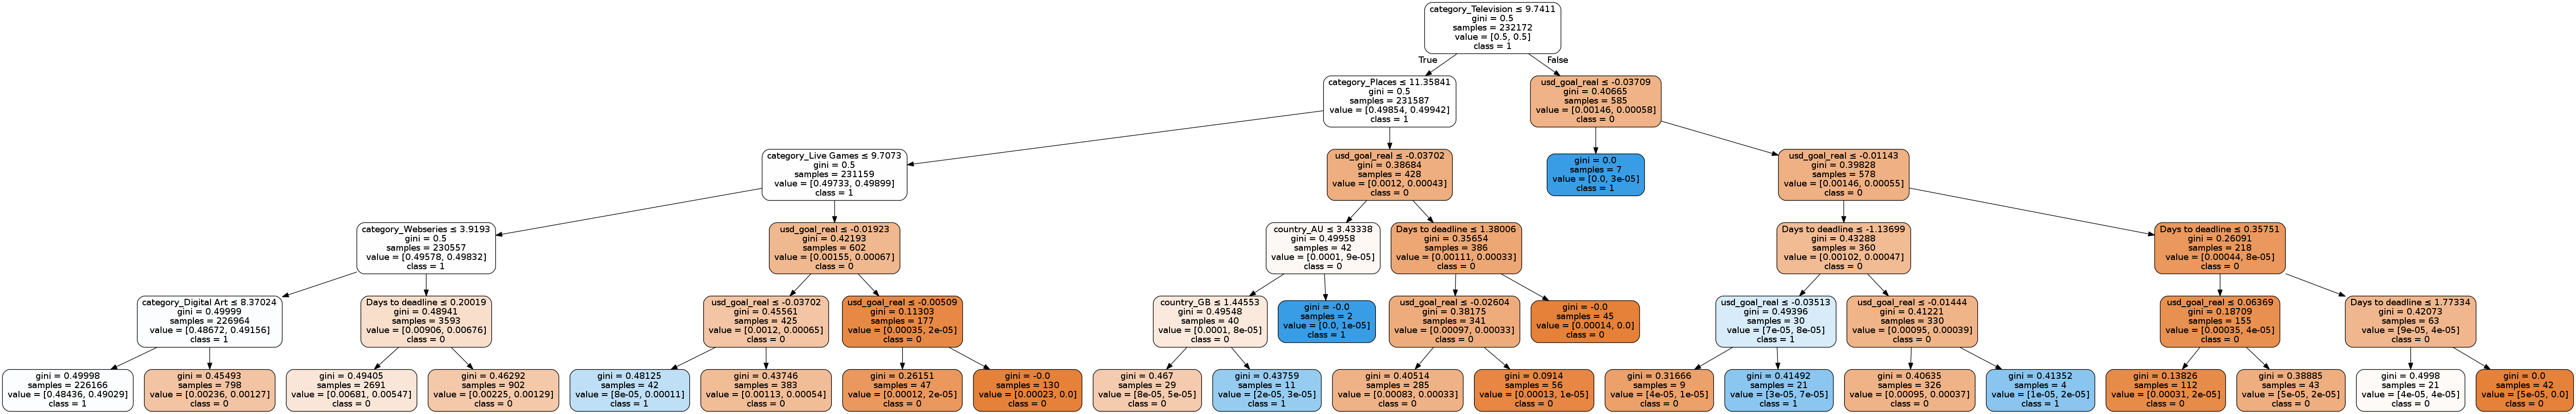

9


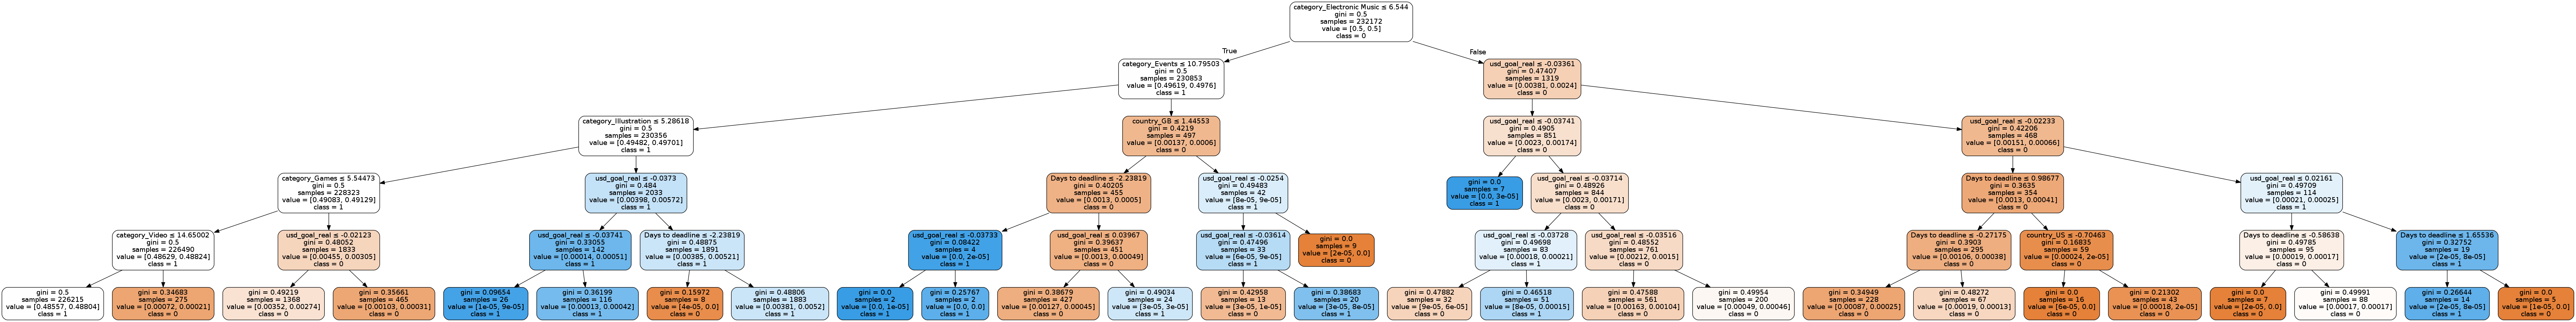

In [25]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,
                         feature_names=X_train.columns,  
                         class_names=["0","1"],  
                         filled=True, rounded=True,  
                         special_characters=True,precision=5) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    #3つ目の決定木のみ出力できなかったので例外処理
    try:
        display(Image(graph.create_png()))
        graph.write_pdf('ks-projects_ada_{}.pdf'.format(i))
    except:
        pass

# 考察

- 目標金額と期間がかなり重要
- アプリケーション、モバイルゲーム、Webなどソフトウェア系が成功しやすい
- USのプロジェクトが成功しやすい